<a href="https://colab.research.google.com/github/Aaricis/Build-Transformer-Form-Scratch/blob/main/%E5%A4%8D%E7%8E%B0Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 动手实现Transformer


为了弄清楚Transformer的实现细节，这里从零开始复现论文[Attention Is All You Need](https://arxiv.org/abs/1706.03762)中执行文本翻译任务的Transformer(Pytorch)。该版本与Pytorch提供的`torch.nn.Transformer`不同略有不同，包含了Embedding的步骤。

## 导入库

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

## Attention

### Scaled Dot-Product Attention
缩放点积注意力机制

给定查询矩阵$Q$、键矩阵$K$、值矩阵$V$，计算Attention如下：

$$
\text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{Q K^\top}{\sqrt{d_k}}\right) V
$$
其中，查询和键向量的维度为$d_k$

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
  """
  缩放点积注意力计算
  参数：
    Q:查询矩阵(batch_size, seq_len, d_k)
    K:键矩阵(batch_size, seq_len, d_k)
    V:值矩阵(batch_size, seq_len, d_v)
    mask:掩码矩阵，用于屏蔽不应该关注的位置(Optional)
  返回：
    output: 注意力矩阵
    attention_weights: 注意力权重矩阵
  """
  d_k = Q.size(-1)

  # 计算点积并缩放
  scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

  # 如果提供掩码矩阵，将掩码对应位置分数设为-inf
  if mask is not None:
    scores = scores.masked_fill(mask == 0, float('-inf'))

  # 对缩放后的分数应用Softmax，得到注意力权重
  attention_weights = F.softmax(scores, dim=-1)

  # 加权求和，计算输出
  output = torch.matmul(attention_weights, V)

  return output, attention_weights


### 多头注意力机制（Multi-Head Attention）
多头注意力机制在Transformer中发挥着与卷积神经网络（CNN）中卷积核类似的作用。CNN使用多个不同的卷积核在空域上捕捉不同的局部信息，而Transformer的多头注意力通过多个头并行地关注输入数据在不同维度上的依赖关系。

假设有$h$个头，每个头拥有独立的线性变换矩阵$W_i^Q$，$W_i^K$，$W_i^V$（分别作用于查询、键和值的映射），每个头的计算如下：
$$
\text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V)
$$

将这些头的输出沿最后一维拼接（Concat），并通过线性变换矩阵$W^O$映射回原始嵌入维度。
$$
\text MultiHead(Q, K, V) = Concat(head_1, ..., head_n)W^O
$$

映射回原始嵌入维度的主要目的是为了实现残差连接（Residual Connection），即：
$$
x + \text SubLayer(x)
$$

你将发现其他模块（如注意力模块、多头注意力机制和前馈网络）的输出层大多都是一样的维度。这是因为只有当输入$x$的形状与经过层变换后的输出$SubLayer(x)$的形状一致时，才能按预期的进行逐元素相加（element-wise addition）,否则会导致张量维度不匹配，需要额外的变换操作。

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, h):
    """
    多头注意力机制
    参数：
      d_model：输入序列的嵌入维度
      h：注意力头数
    """
    super(MultiHeadAttention, self).__init__()
    assert d_model % h == 0

    self.d_model = d_model
    self.h = h

    # "共享"的Q，K，V线性层
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    # 输出线性层，将多头拼接后的输出映射回d_model
    self.fc_out = nn.Linear(d_model, d_model)

  def forward(self, q, k, v, mask=None):
    """
    参数：
      q: 查询矩阵 (batch_size, seq_len_q, d_model)
      k: 键矩阵 (batch_size, seq_len_k, d_model)
      v: 值矩阵 (batch_size, seq_len_v, d_model)
      mask: 掩码矩阵 (batch_size, 1, seq_len_q, seq_len_k)

    返回：
      out: 注意力加权后的输出
      attention_weights: 注意力权重矩阵
    """
    batch_size = q.size(0)

    # 获取查询和键值的序列长度
    seq_len_q = q.size(1)
    seq_len_k = k.size(1)
    seq_len_v = v.size(1)

    # 将输入tensor拆分为多个头，并调整维度顺序以便并行计算注意力
    Q = self.w_q(q).view(batch_size, seq_len_q, self.h, -1).transpose(1, 2) # (batch_size, seq_len_q, d_model)->(batch_size, seq_len_q, d_k)->(batch_size, seq_len_q, h, head_dim)->(batch_size, h, seq_len_q, head_dim)
    K = self.w_k(k).view(batch_size, seq_len_k, self.h, -1).transpose(1, 2)
    V = self.w_v(v).view(batch_size, seq_len_v, self.h, -1).transpose(1, 2)

    # 执行缩放点积注意力
    scaled_attention, _ = scaled_dot_product_attention(Q, K, V, mask)

    # 合并多头并还原为(batch_size, seq_len_q, d_model)
    concat_out = scaled_attention.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model) # (batch_size, h, seq_len, depth_per_head)->(batch_size, seq_len, h, depth_per_head)->(batch_size, seq_len_q, d_model)

    # 通过输出线性层
    out = self.fc_out(concat_out)

    return out



## Position-wise Feed-Forward Networks

Encoder-Decoder架构中，另一个看起来“大一点”的模块就是Feed Forward，它在每个位置$i$上的计算可表示为：
$$
\text FFN(x_i) = max(0, x_iW_1 + b_1)W_2+b_2
$$

其中：
- $x_i \in \mathbb{R}^{d_{\text{model}}}$表示第$i$个位置的输入向量；
- $W_1 \in \mathbb{R}^{d_{\text{model}} \times d_{\text{ff}}}$ 和$W_2 \in \mathbb{R}^{d_{\text{ff}} \times d_{\text{model}}}$是两个线性变换的权重矩阵；
- $b_1 \in \mathbb{R}^{d_{\text{ff}}}$ 和$b_2 \in \mathbb{R}^{d_{\text{model}}}$是对应的偏置向量；
- $max(0, .)$是ReLu激活函数，用于引入非线性。

Position-wise实际是线性层本身的一个特性，在线性层中，每个输入向量（对应于序列中的一个位置，比如一个词向量）都会通过相同的权重矩阵进行线性变换。这意味着每个位置的处理是相互独立的，逐元素这一点可以看成kernal_size=1的卷积核扫过一遍序列。

FFN本质就是两个线性变换之间嵌入了一个ReLu激活函数。

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff):
    """
    位置前馈网络

    参数：
      d_model：输入输出向量维度
      d_ff：FFN隐藏层维度
    """
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff) # 第一个线性层
    self.w_2 = nn.Linear(d_ff, d_model) # 第二个线性层

  def forward(self, x):
    return self.w_2(self.w_1(x).relu())

## 残差连接（Residual Connection）和层归一化（Layer Normalization，LayerNorm）

在Transformer架构中，残差连接（Residual Connection）与层归一化（LayerNorm）结合使用，统称为Add&Norm操作。

### Add（残差连接，Residual Connection）

> **ResNet**
> Deep Residual Learning for Image Recognition | [arXiv 1512.03385](https://arxiv.org/pdf/1512.03385)

> **简单，但有效**
残差连接是一种跳跃连接（Skip Connection），它将层的输入直接加到输出上，公式如下：

$$
\text{Output} = \text{SubLayer}(x) + x
$$

这种连接方式有效缓解了**深层神经网络的梯度消失**问题。

Q：为什么可以缓解梯度消失？

首先，了解什么是梯度消失？

在深度神经网络中，参数的梯度通过反向传播计算，公式为：

$$
\frac{\partial \mathcal{L}}{\partial W} = \frac{\partial \mathcal{L}}{\partial h_n} \cdot \frac{\partial h_n}{\partial h_{n-1}} \cdot \ldots \cdot \frac{\partial h_1}{\partial W}
$$

当网络层数增加时，链式法则中的梯度相乘可能导致梯度值越来越小（梯度消失）或越来越大（梯度爆炸），使得模型难以训练和收敛。

假设输出层的损失为$\mathcal{L}$，且$\text{SubLayer}(x)$表示为$F(x)$。在没有残差连接的情况下，梯度通过链式法则计算为：

$$
\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial F(x)} \cdot \frac{\partial F(x)}{\partial x}
$$

如果$\frac{\partial F(x)}{\partial x}$的绝对值小于1，那么随着层数的增加，梯度会快速缩小，导致梯度消失。

引入残差连接后，输出变为$F(x) + x$，其梯度为：

$$
\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial (x + F(x))} \cdot (1 + \frac{\partial F(x)}{\partial x})
$$

这里包含一个常数项1，这意味着即使$\frac{\partial F(x)}{\partial x}$很小，梯度仍然可以有效地反向传播，缓解梯度消失问题。

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self, dropout=0.1):
    """
    残差连接，用于在每个子层后添加残差连接和Dropout
    """
    super(ResidualConnection, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x, sublayer):
    """
    参数：
      x：残差连接的输入张量，形状为(batch_size, seq_len, d_model)
      sublayer：子层模块函数，多头注意力机制或前馈网络

    返回：
      经过残差连接和Dropout处理后的张量，形状为(batch_size, seq_len, d_model)
    """
    # 将子层输出应用 dropout，然后与输入相加（参见论文 5.4 的表述或者本文「呈现」部分）
    return x + self.dropout(sublayer(x))

### Norm（层归一化，Layer Normalization）

> Layer Normalization | [arXiv 1607.06450](https://arxiv.org/pdf/1607.06450)

层归一化（LayerNorm）是一种归一化技术，用于提升训练的稳定性和模型的泛化能力。

Q：BatchNorm和LayerNorm的区别

如果你听说过Batch Normalization(BatchNorm)，或许会疑惑于二者的区别。

假设输入张量的形状为(batch_size, feature_size)，其中`batch_size=32`，`feature_size=512`。
- batch_size：表示批次中的样本数量；
- feature_size：表示每个样本的特征维度，即每个样本包含512维特征。

这里的一行对应于一个样本，一列对应于一种特征属性。

- BatchNorm基于一个批次（batch）内的所有样本，针对特征维度（列）进行归一化。即在每一列（相同特征或嵌入维度上的batch_size个样本）上计算均值和方差。
  
  - 对第$j$列（特征）计算均值和方差：
    
    $$
    \mu_j = \frac{1}{\text{batch\_size}} \sum_{i=1}^{\text{batch\_size}} x_{i,j}, \quad
    \sigma^2_j = \frac{1}{\text{batch\_size}} \sum_{i=1}^{\text{batch\_size}} (x_{i,j} - \mu_j)^2
    $$
  - LayerNorm基于每个样本的所有特征，针对样本自身（行内所有特征）进行归一化。即在每一行（一个样本的$feature_size$个特征）上计算均值和方差。
    
    - 对第$i$行（样本）计算均值和方差：
    $$
    \mu_i = \frac{1}{\text{feature\_size}} \sum_{j=1}^{\text{feature\_size}} x_{i,j}, \quad
    \sigma^2_i = \frac{1}{\text{feature\_size}} \sum_{j=1}^{\text{feature\_size}} (x_{i,j} - \mu_i)^2
    $$

#### LayerNorm 的计算过程
假设输入向量为$ x = (x_1, x_2, ..., x_d) $，LayerNorm的计算步骤如下：
1. **计算均值和方差**：对输入的所有特征求均值$\mu$和方差$\sigma^2$：
  $$
  \mu = \frac{1}{d} \sum_{j=1}^{d} x_j, \quad
  \sigma^2 = \frac{1}{d} \sum_{j=1}^{d} (x_j - \mu)^2
  $$
2. **归一化公式**：将输入特征$\hat x_i$进行归一化：
  $$
   \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
  $$
其中，$\epsilon$是一个很小的常数（比如1e-9），防止除零的情况。

3. **引入可学习参数**：归一化后的输出乘以$\gamma$，并加上$\beta$，公式如下：
  $$
   \text{Output} = \gamma \hat{x} + \beta
  $$

其中，$\gamma$和$\beta$是可学习的参数，用于进一步调整归一化后的输出。


In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, feature_size, epsilon=1e-9):
    """
    层归一化，用于对最后一个维度进行归一化。

    参数：
      feature_size：输入特征的维度大小，即归一化的特征维度；
      epsilon：防止除零的常数。
    """
    super(LayerNorm, self).__init__()
    self.gamma = nn.Parameter(torch.ones(feature_size)) # 可学习缩放参数，初始值为 1
    self.beta = nn.Parameter(torch.zeros(feature_size)) # 可学习偏移参数，初始值为 0
    self.epsilon = epsilon

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    std = x.std(dim=-1, keepdim=True)
    return self.gamma * (x - mean) / (std + self.epsilon) + self.beta


### Add & Norm
1. 残差连接：将输入直接与输出相加；
2. 层归一化：对相加后的结果进行归一化。

公式如下：

$$
\text{Output} = \text{LayerNorm}(x + \text{SubLayer}(x))
$$

其中，$\text{SubLayer}(x)$表示Transformer中的某个子层（例如，自注意力层或前馈网络层）的输出。

In [ ]:
class SublayerConnection(nn.Module):
  def __init__(self, feature_size, dropout=0.1, epsilon=1e-9):
    """
    子层连接，包括残差连接和层归一化，应用于Transformer的每一个子层。

    参数：
      feature_size：输入特征的维度大小，即归一化的特征维度；
      dropout：残差连接中的dropout概率；
      epsilon：防止除零的常数。
    """
    super(SublayerConnection, self).__init__()
    self.residual = ResidualConnection(dropout) # 使用 ResidualConnection 进行残差连接
    self.norm = LayerNorm(feature_size, epsilon) # 层归一化

  def forward(self, x, sublayer):
    # 将子层输出应用dropout后经过残差连接后再进行归一化
    return self.norm(self.residual(x, sublayer))

## 嵌入

在Transformer模型中，**嵌入层**（Embedding Layer）是处理输入和输出数据的关键步骤。因为，模型实际操作的是**张量**（tensor），而非字符串（string）。在将输入文本传递给模型之前，首先要进行**分词**（tokenization），即将文本拆解为多个token，随后这些token会被映射为对应的**token ID**，从而转换为模型可理解的数值形式。此时，数据的形状`(seq_len,)`，其中`seq_len`表示输入序列的长度。

Q：为什么需要嵌入层？

因为token ID只是整数标识符，彼此之间没有内在联系。如果直接使用这些整数，模型可能在训练过程中学习到一些模式，但无法充分捕捉词汇之间的语义关系。

因此，为了让模型捕捉到token背后复杂的**语义关系（Semantic meaning）**，我们需要将离散的token ID映射到一个高维的连续向量空间。每个token ID会被转换为一个**嵌入向量（embedding vector）**，期望通过这种方式让语义相近的词汇向量在空间中距离更近，使模型能更好捕捉词汇之间的关系。当然，简单的映射无法做到这一点，因此需要“炼丹”——是的，嵌入层是可以训练的。

- `nn.Embedding`：创建嵌入层，将词汇表中的每个token ID映射为对应的嵌入向量；
- `vocab_size`：词汇表的大小；
- `d_model`：嵌入向量的维度大小。

**特殊设计：**
- **缩放嵌入（Scaled Embedding）**:将嵌入层的输出（参数）乘以$\sqrt{d_{\text{model}}}$。

In [ ]:
class Embeddings(nn.Module):
  """
  嵌入，将token ID转换为固定维度的嵌入向量，并进行缩放。
  参数：
    vocab_size：词汇表大小；
    d_model：嵌入向量的维度。
  """
  def __init__(self, vocab_size, d_model):
    super(Embeddings, self).__init__()
    self.embed = nn.Embedding(vocab_size, d_model)
    self.scale_factor = math.sqrt(d_model)

  def forward(self, x):
    """
    参数：
      x：输入张量（token ID）,形状为（batch_size, seq_len）；

    返回：
      缩放后的嵌入向量，形状为（batch_size, seq_len，d_model）。
    """
    return self.embed(x) * self.scale_factor

### Q: 什么是 nn.Embedding()？和 nn.Linear() 的区别是什么？

- nn.Embedding()是一个简单的查找表，存储固定字典和大小的嵌入。该模块通常用来存储词嵌入并使用索引检索它们。模块的输入是索引列表，输出是相应的词嵌入。

- nn.Linear()是线性变换。

对比二者的`forward()`方法：

```python
# Embedding
def forward(self, input):
  return self.weight[input] # 直接返回对应的行

# Linear
def forward(self, input):
  torch.matmul(input, self.weight.T) + self.bias

```





In [ ]:
# 测试nn.Embedding()
import torch
import torch.nn as nn

# 设置随机种子
torch.manual_seed(42)

# nn.Embedding() 权重矩阵形状为 (num_embeddings, embedding_dim)
num_embeddings = 5  # 假设有 5 个 token
embedding_dim = 3   # 每个 token 对应 3 维嵌入

# 初始化嵌入层
embedding = nn.Embedding(5, 3)

# 整数索引
input_indices = torch.tensor([0, 2, 4])

# 查找嵌入
output = embedding(input_indices)

# 打印结果
print("权重矩阵：")
print(embedding.weight.data)
print("\nEmbedding 输出：")
print(output)

权重矩阵：
tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863],
        [ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094],
        [ 1.1103, -1.6898, -0.9890]])

Embedding 输出：
tensor([[ 0.3367,  0.1288,  0.2345],
        [ 2.2082, -0.6380,  0.4617],
        [ 1.1103, -1.6898, -0.9890]], grad_fn=<EmbeddingBackward0>)


## Softmax
在Transformer模型中，**Softmax**函数不仅在计算**注意力权重**时用到，在预测阶段的输出处理环节也会用到。因为预测token的过程可以看成是**多分类问题**。

**Softmax**函数是一种常用的激活函数，能够将任意实数向量转换为**概率分布**，确保每个元素的取值范围在[0, 1]之间，并且所有元素的和为1。其数学定义如下：

$$
\text{Softmax}(x_i)= \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

其中：
- $x_i$表示输入向量中的第$i$个元素；
- $\text{Softmax}(x_i)$表示输入$x_i$转换后的概率。

我们可以把Softmax看作一种**归一化的指数变换**。相比于简单的比例归一化$\frac {x_i}{\sum_{j}{x_j}}$，Softmax通过指数变换放大数值间的差异，让较大的值对应更高的概率，同时避免了负值和数值过小的问题。


实际使用时可以直接调用`nn.Softmax()`，出于学习的目的，这里手动实现一个简单的Softmax函数，并与`nn.Softmax()`的结果进行对比，以加深公式的印象。

In [ ]:
import torch
import torch.nn as nn

def softmax(x):
  exp_x = torch.exp(x)
  sum_exp_x = torch.sum(exp_x, dim=-1, keepdim=True)
  return exp_x / sum_exp_x

# 测试向量
x = torch.tensor([1.0, 2.0, 3.0])

# 根据公式实现的 Softmax
result = softmax(x)

# 使用 nn.Softmax
softmax = nn.Softmax(dim=-1)
nn_result = softmax(x)

print("根据公式实现的 Softmax 结果：", result)
print("nn.Softmax 的结果：", nn_result)

根据公式实现的 Softmax 结果： tensor([0.0900, 0.2447, 0.6652])
nn.Softmax 的结果： tensor([0.0900, 0.2447, 0.6652])


## 位置编码（Positional Encoding）

由于Transformer模型不是循环（RNN）结构，模型本身无法捕捉输入序列中元素的位置信息。注意力机制的计算过程中，注意力得分（score）是通过查询向量（query）和键向量（key）之间的内积得到的。生成的注意力权重（attention weights）也只是基于这些内积，不会捕捉到位置信息。

例如，把序列`[A, B, C]`打乱顺序得到`[B, A, C]`，输出也会是原来的结果按同样方式打乱后的形式。假设原输出为`[Z_A, Z_B, Z_C]`，打乱后的输出将变为`[Z_B, Z_A, Z_C]`。

如果嵌入向量本身不包含位置信息，意味着**输入元素的顺序不会影响输出的权重计算**，模型无法从中捕捉到序列的顺序信息。换句话说，只是输出的位置跟着对应变化，但对应的计算结果不会改变。可以用一句诗概括这个现象：「天涯若比邻」。

为了解决这个问题，Transformer引入了**位置编码（Positional Encoding）**：为每个位置生成一个向量，这个向量与对应的嵌入向量相加，从而在输入中嵌入位置信息。

在原始论文中，Transformer使用的是固定位置编码（Positional Encoding），公式如下：

$$
\text{PE}_{(pos,2i)}=\text{sin}(\frac{pos}{10000^{2i/d_{model}}}),
\text{PE}_{(pos,2i+1)}=\text{cos}(\frac{pos}{10000^{2i/d_{model}}})
$$

其中：
- $pos$表示位置索引；
- $i$表示维度索引；
- $d_{model}$是嵌入向量的维度。



In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=5000):
    """
    位置编码，为输入序列中的每个位置添加唯一的位置表示，以引入位置信息。
    参数：
      d_model：嵌入维度，即每个位置的编码向量的维度；
      dropout：位置编码后应用的dropout概率；
      max_len：位置编码的最大长度，适应不同长度的输入序列。
    """
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    # 创建位置编码矩阵，形状为(max_len, d_model)
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1) # 位置索引(max_len, 1)

    # 计算每个维度对应的频率
    # 通过指数和对数变换等效实现
    div_term = torch.exp(
       torch.arange(0, d_model, 2) * (-math.log(10000.0)) / d_model
    )

    # 将位置和频率结合，计算sin和cos
    pe[:, 0::2] = torch.sin(position * div_term) # 偶数维度
    pe[:, 1::2] = torch.cos(position * div_term) # 奇数维度

    # 增加一个维度，方便后续与输入相加，形状变为(1, max_len, d_model)
    pe = pe.unsqueeze(0)

    # 将pe注册为模型的缓冲区（buffer），而不是可训练参数（parameter），用于存储不需要梯度更新但需要随模型保存/加载的持久化数据。
    self.register_buffer('pe', pe)

  def forward(self, x):
    """
    forward函数

    参数：
      x：输入序列的嵌入向量，形状为(batch_size, seq_len, d_model)。
    返回：
      加入位置编码和Dropout后的嵌入向量，形状为(batch_size, seq_len, d_model)。
    """
    # 取出与输入序列长度相同的部分位置编码，并与输入相加
    x = x + self.pe[:, :x.size(1), :]
    # :x.size(1) 选取前 seq_len 个位置编码，得到 (1, seq_len, d_model)
    # x的形状为(batch_size, seq_len, d_model)
    # self.pe 截取后的形状为 (1, seq_len, d_model)，通过广播机制扩展到 (batch_size, seq_len, d_model)
    # 逐元素相加将位置信息叠加到输入嵌入上
    return self.dropout(x)


### 数学解释
位置编码的频率项公式为：
$$
\text{div_term}_i =\frac {1} {10000^{2i/d_{model}}}
$$
代码通过指数和对数变换等效实现：
$$
\text{div_term}_i = \text{exp}^{-\frac {2i}{d_{model}}log(10000)}
$$

```python
div_term = torch.exp(
       torch.arange(0, d_model, 2) * (-math.log(10000.0)) / d_model
    )
```
- `torch.arange(0, d_model, 2)`：
生成偶数索引序列，$[0, 2, 4,..., d_{model} - 2]$，对应公式中的$2i$；
- `-math.log(10000.0)`：计算$-log(10000)$，是常数项；
- 逐元素相乘后除以$d_{model}$，等价于$-\frac {2i}{d_{model}}log(10000)$；
- `torch.exp()`最终得到$\frac {1} {10000^{2i/d_{model}}}$。



### 可视化

In [ ]:
def visualize_positional_encoding():
  # 初始化位置编码类，设置嵌入向量维度为20，dropout概率为0，最大序列长度为100
  pe = PositionalEncoding(20, dropout=0, max_len=100)
  # 输入一个全零张量 (batch_size=1, seq_len=100, d_model=20)，通过 forward 方法叠加位置编码。
  y = pe.forward(torch.zeros(1, 100, 20))

  # 设置图形大小为 12x6
  plt.figure(figsize=(12, 6))
  # 可视化第 4 到第 7 维的编码值
  for dim in [4, 5, 6, 7]:
      plt.plot(range(100), y[0, :, dim].numpy(), label=f'Dimension {dim}')

  # 设置图形标题、坐标轴标签和网格
  plt.title("Positional Encoding Visualization")
  plt.xlabel("Position")
  plt.ylabel("Encoding Value")
  plt.legend(title="Dimensions")
  plt.grid(True)

  # 将图像保存为 PNG 格式
  plt.savefig("positional_encoding.png", format="png", dpi=300, bbox_inches='tight')
  plt.show()

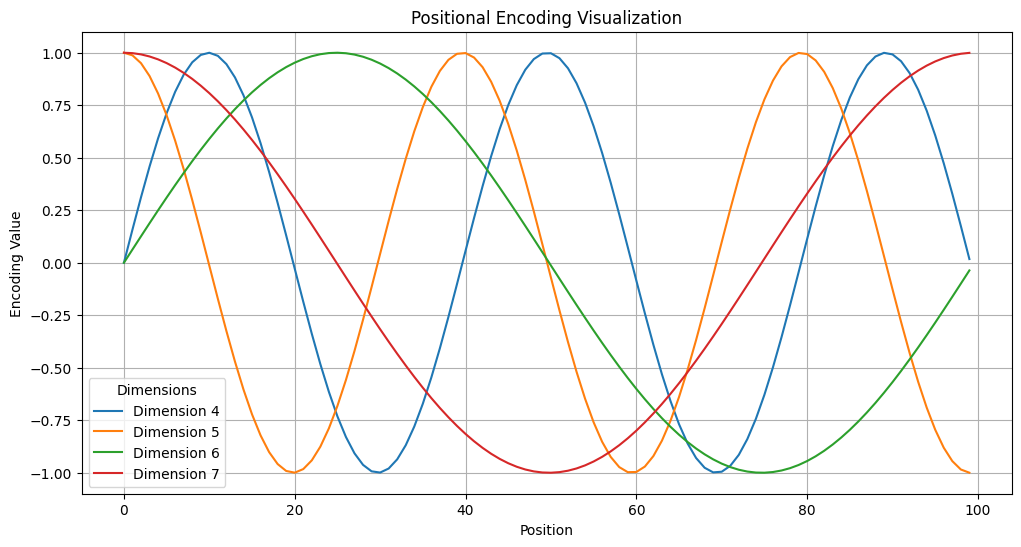

In [ ]:
# 可视化位置编码并进行保存
visualize_positional_encoding()

## 输入处理

### 编码器输入处理
编码器的输入由输入嵌入（Input Embedding）和位置编码（Positional Encoding）组成。在机器翻译任务中，还可以称为源语言嵌入（Source Embedding）。

In [ ]:
class SourceEmbedding(nn.Module):
  def __init__(self, src_vocab_size, d_model, dropout=0.1):
    """
    源序列嵌入，将输入的token序列转换为嵌入向量并添加位置编码。

    参数：
      src_vocab_size：源语言词汇表的大小
      d_model：嵌入向量的维度
      dropout：在位置编码后应用的dropout概率
    """
    super(SourceEmbedding, self).__init__()
    self.embed = Embeddings(src_vocab_size, d_model) # 词嵌入层
    self.positional_encoding = PositionalEncoding(d_model, dropout) # 位置编码层

  def forward(self, x):
    """
    参数：
      x：源语言序列的输入张量，形状为(batch_size, seq_len_src)，其中每个元素是token Id；
    返回：
      添加位置编码后的嵌入向量，形状为(batch_size, seq_len_src, d_model)；
    """
    x = self.embed(x) # 生成词嵌入(batch_size, seq_len_src, d_model)
    return self.positional_encoding(x) # 加入位置编码

### 解码器输入处理

解码器的输入由输出嵌入（Output Embedding）和位置编码（Positional Encoding）组成。在机器翻译这个任务中也可以称为目标语言嵌入（Target Embedding）。为了避免与最终输出混淆，使用`TargetEmbedding`实现。

In [ ]:
class TargetEmbedding(nn.Module):
  def __init__(self, tgt_vocab_size, d_model, dropout=0.1):
    """
    目标序列嵌入，将目标序列的token Id转换为嵌入向量并添加位置编码。

    参数：
      tgt_vocab_size：目标语言词汇表的大小；
      d_model：嵌入向量的维度；
      dropout：在位置编码后应用dropout概率；
    """
    super(TargetEmbedding, self).__init__()
    self.embed = Embeddings(tgt_vocab_size, d_model) # 词嵌入层
    self.positional_encoding = PositionalEncoding(d_model, dropout) # 位置编码层

  def forward(self, x):
    """
    参数：
      x：源语言序列的输入张量，形状为(batch_size, seq_len_src)，其中每个元素是token Id；
    返回：
      添加位置编码后的嵌入向量，形状为(batch_size, seq_len_src, d_model)；
    """
    x = self.embed(x) # 生成词嵌入(batch_size, seq_len_src, d_model)
    return self.positional_encoding(x) # 加入位置编码

## 掩码
在Transformer模型中，掩码用于控制注意力机制中哪些位置需要被忽略。为什么需要掩码？
- **处理变长序列：填充掩码（Padding Mask）**

  批量训练时，序列长度不一致，需填充短序列至相同长度。防止填充符（如<pad>）参与计算，避免影响模型对真实数据的建模。
- **防止信息泄露：序列掩码（Sequence Mask）**

  解码器在预测第t个位置时，不应看到未来时刻（t+1及之后）的信息。


### 填充掩码（Padding Mask）
填充掩码用于在注意力计算时屏蔽填充`<PAD>`位置，防止模型计算注意力权重的时候考虑这些无意义的位置，在编码器的自注意力中使用。

In [ ]:
def create_padding_mask(seq, pad_token=0):
  # seq 的形状为 (batch_size, seq_len)
  mask = (seq != pad_token).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, seq_len)
  return mask

In [ ]:
# 举个例子

seq = torch.tensor([[1, 2, 0, 0], [3, 0, 0, 0]])  # batch_size=2, seq_len=4
mask = create_padding_mask(seq, pad_token=0)
print(mask.shape)  # 输出: torch.Size([2, 1, 1, 4])
print(mask)
# 输出:
# tensor([[[[ True,  True, False, False]]],
#        [[[ True, False, False, False]]]])

torch.Size([2, 1, 1, 4])
tensor([[[[ True,  True, False, False]]],


        [[[ True, False, False, False]]]])


In [ ]:
attn_scores = torch.randn(2, 8, 4, 4)  # (batch_size=2, num_heads=8, seq_len=4, seq_len)
print(attn_scores)
masked_scores = attn_scores.masked_fill(~mask, float('-inf'))  # 将填充位置设为 -inf
print(masked_scores)

tensor([[[[-1.3847e+00, -8.7124e-01, -2.2337e-01,  1.7174e+00],
          [ 3.1888e-01, -4.2452e-01,  3.0572e-01, -7.7459e-01],
          [-1.5576e+00,  9.9564e-01, -8.7979e-01, -6.0114e-01],
          [-1.2742e+00,  2.1228e+00, -1.2347e+00, -4.8791e-01]],

         [[-9.1382e-01, -6.5814e-01,  7.8024e-02,  5.2581e-01],
          [-4.8799e-01,  1.1914e+00, -8.1401e-01, -7.3599e-01],
          [-1.4032e+00,  3.6004e-02, -6.3477e-02,  6.7561e-01],
          [-9.7807e-02,  1.8446e+00, -1.1845e+00,  1.3835e+00]],

         [[ 1.4451e+00,  8.5641e-01,  2.2181e+00,  5.2317e-01],
          [ 3.4665e-01, -1.9733e-01, -1.0546e+00,  1.2780e+00],
          [-1.7219e-01,  5.2379e-01,  5.6622e-02,  4.2630e-01],
          [ 5.7501e-01, -6.4172e-01, -2.2064e+00, -7.5080e-01]],

         [[ 1.0868e-02, -3.3874e-01, -1.3407e+00, -5.8537e-01],
          [ 5.3619e-01,  5.2462e-01,  1.1412e+00,  5.1644e-02],
          [ 7.4395e-01, -4.8158e-01, -1.0495e+00,  6.0390e-01],
          [-1.7223e+00, -8.2777e-0

### 序列掩码（Sequence Mask）
序列掩码用于在解码器中屏蔽未来的位置，防止模型在预测下一个词时“偷看”答案，在解码器中使用。

In [ ]:
def create_look_ahead_mask(size):
  mask = torch.tril(torch.ones(size, size)).type(torch.bool) # 下三角矩阵
  return mask # (seq_len, seq_len)

In [ ]:
# 举个例子
print(create_look_ahead_mask(5))

tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]])


### 组合填充掩码和序列掩码
在实际应用中，我们需要将填充掩码和未来信息掩码进行组合，以同时实现两种掩码的效果。


In [ ]:
def create_decoder_mask(tgt_seq, pad_token=0):
  padding_mask = create_padding_mask(tgt_seq, pad_token) # (batch_size, 1, 1, seq_len_tgt)
  look_ahead_mask = create_look_ahead_mask(tgt_seq.size(1)).to(tgt_seq.device) # (seq_len_tgt, seq_len_tgt)
  combined_mask = look_ahead_mask.unsqueeze(0) & padding_mask # (batch_size, 1, seq_len_tgt, seq_len_tgt)
  return combined_mask

## 子层模块

### 编码器层（Encoder Layer）
**组件：**
- 多头自注意力 (Multi-Head Self-Attention)
- 前馈神经网络 (Feed Forward)
- 残差连接和归一化(Add & Norm)，或称之为子层连接(SublayerConnection)

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, h, d_ff, dropout):
    """
    编码器层

    参数：
      d_model：嵌入维度
      h：多头注意力的头数
      d_ff：前馈神经网络的隐藏层维度
      dropout：dropout概率
    """
    super(EncoderLayer, self).__init__()
    self.self_attn = MultiHeadAttention(d_model, h) # 多头自注意力（Multi-Head Self-Attention）
    self.feed_forward = PositionwiseFeedForward(d_model, d_ff)

    # 子层连接（残差连接 + 层归一化），共两个（分别用于自注意力和前馈网络）
    self.sublayers = nn.ModuleList([SublayerConnection(d_model, dropout) for _ in range(2)])
    self.d_model = d_model

  def forward(self, x, src_mask):
    """
    参数：
      x：输入张量，形状为(batch_size, seq_len, d_model)；
      src_mask：源序列掩码，用于自注意力机制。

    返回：
      编码器层的输出，形状为(batch_size, seq_len, d_model)。
    """
    # 通过 self.self_attn(x, x, x, src_mask) 计算自注意力（Query=Key=Value=x）。
    # 使用 SublayerConnection 包装：output = LayerNorm(x + Dropout(sublayer(x)))
    x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, src_mask)) # 自注意力子层
    x = self.sublayers[1](x, self.feed_forward) # 前馈子层
    return x

### 解码器层（Decoder Layer）
**组件：**
- 掩码多头自注意力(Masked Multi-Head Self-Attention)
- 多头交叉注意力(Multi-Head Cross-Attention)
- 前馈神经网络(Feed Forward)
- 残差连接和归一化(Add & Norm)，或称之为子层连接(SublayerConnection)

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, h, d_ff, dropout):
    """
    解码器层

    参数：
      d_model：嵌入维度
      h：多头注意力的头数
      d_ff：前馈神经网络的隐藏层维度
      dropout：dropout概率
    """
    super(DecoderLayer, self).__init__()
    self.self_attn = MultiHeadAttention(d_model, h) # 掩码多头自注意力（Masked Multi-Head Self-Attention）
    self.cross_attn = MultiHeadAttention(d_model, h) # 多头交叉注意力（Multi-Head Cross-Attention）
    self.feed_forward = PositionwiseFeedForward(d_model, d_ff)  # 前馈神经网络

    # 定义三个子层连接，分别用于掩码多头自注意力、多头交叉注意力和前馈神经网络（对应模型架构图中的三个残差连接）
    self.sublayers = nn.ModuleList([SublayerConnection(d_model, dropout) for _ in range(3)])
    self.d_model = d_model

  def forward(self, x, memory, src_mask, tgt_mask):
    """
    参数：
      x：输入张量，形状为(batch_size, seq_len_tgt, d_model)；
      memory：编码器输出，形状为(batch_size, seq_len_src, d_model)
      src_mask：源序列掩码，用于交叉自注意力机制；
      tgt_mask：目标序列掩码，用于自注意力。
    返回：
      x：解码器层的输出
    """
    # 第一个子层：掩码多头自注意力（Masked Multi-Head Self-Attention）
    x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))

    # 第二个子层：交叉多头注意力（Multi-Head Cross-Attention），使用编码器的输出 memory
    x = self.sublayers[1](x, lambda x: self.cross_attn(x, memory, memory, src_mask))

    # 第三个子层：前馈神经网络
    x = self.sublayers[2](x, self.feed_forward)

    return x


### 编码器（Encoder）

In [ ]:
class Encoder(nn.Module):
  def __init__(self, d_model, N, h, d_ff, dropout=0.1):
    """
    编码器，由N个EncoderLayer堆叠而成。

    参数：
      d_model：嵌入维度
      N：编码器层的数量
      h：多头注意力的头数
      d_ff：前馈神经网络的隐藏层维度
      dropout：dropout概率
    """
    super(Encoder, self).__init__()
    self.layers = nn.ModuleList([
      EncoderLayer(d_model, h, d_ff, dropout) for _ in range(N)
    ])
    self.norm = LayerNorm(d_model) # 最后层归一化

  def forward(self, x, mask):
    """
    参数：
      x：输入张量，形状为(batch_size, seq_len_tgt, d_model)；
      mask：输入掩码
    返回：
      编码器的输出
    """
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x) # 最后层归一化


### 解码器（Decoder）

In [ ]:
class Decoder(nn.Module):
  def __init__(self, d_model, N, h, d_ff, dropout=0.1):
    """
    解码器，由N个DecoderLayer堆叠而成。

    参数：
      d_model：嵌入维度
      N：编码器层的数量
      h：多头注意力的头数
      d_ff：前馈神经网络的隐藏层维度
      dropout：dropout概率
    """
    super(Decoder, self).__init__()
    self.layers = nn.ModuleList([
        DecoderLayer(d_model, h, d_ff, dropout) for _ in range(N)
    ])
    self.norm = LayerNorm(d_model) # 最后层归一化

  def forward(self, x, memory, src_mask, tgt_mask):
    """
    参数：
      x：输入张量，形状为(batch_size, seq_len_tgt, d_model)；
      memory：编码器输出，形状为(batch_size, seq_len_src, d_model)
      src_mask：源序列掩码，用于交叉自注意力机制；
      tgt_mask：目标序列掩码，用于自注意力。
    返回：
      解码器的输出
    """
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x) # 最后层归一化

## 完整模型

**组件：**
- **输入嵌入和位置编码：**
  - `SourceEmbedding`：对源序列进行嵌入并添加位置编码；
  - `TargetEmbedding`：对目标序列进行嵌入并添加位置编码；
- **多头注意力和前馈网络：**
  - `MultiHeadAttention`：多头注意力机制；
  - `PositionwiseFeedForward`：位置前馈网络；
- **编码器和解码器：**
  - `Encoder`：由多个`EncoderLayer`堆叠而成；
  - `Decoder`：由多个`DecoderLayer`堆叠而成；
- **输出层：**
  - `fc_out`：线性层，将解码器的输出映射到目标词汇表维度。

In [ ]:
class Transformer(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, d_model, N, h, d_ff, dropout=0.1):
    """
    Transformer模型，由编码器和解码器组成。

    参数：
      src_vocab_size：源语言词汇表大小
      tgt_vocab_size：目标语言词汇表大小
      d_model：嵌入维度
      N：编码器和解码器的层数
      h：多头注意力的头数
      d_ff：前馈神经网络的隐藏层维度
      dropout：dropout概率
    """
    super(Transformer, self).__init__()

    # 输入嵌入和位置编码，src对应于编码器输入，tgt对应于解码器输入
    self.src_embedding = SourceEmbedding(src_vocab_size, d_model, dropout)
    self.tgt_embedding = TargetEmbedding(tgt_vocab_size, d_model, dropout)

    # 编码器和解码器
    self.encoder = Encoder(d_model, N, h, d_ff, dropout)
    self.decoder = Decoder(d_model, N, h, d_ff, dropout)

    # 输出线性层
    self.fc_out = nn.Linear(d_model, tgt_vocab_size)

  def forward(self, src, tgt):
    """
    参数：
      src：源序列输入(batch_size, seq_len_src)
      tgt：目标序列输入(batch_size, seq_len_tgt)
    返回：
      Transformer的输出
    """
    # 生成掩码
    src_mask = create_padding_mask(src)
    tgt_mask = create_decoder_mask(tgt)

    # 编码器
    enc_output = self.encoder(self.src_embedding(src), src_mask)

    # 解码器
    dec_output = self.decoder(self.tgt_embedding(tgt), enc_output, src_mask, tgt_mask)

    # 输出层
    output = self.fc_out(dec_output)

    return output

### 实例化
使用Transformer base的参数配置来实例化模型并打印模型架构：

In [ ]:
# 定义词汇表大小
src_vocab_size = 5000 # 源语言词汇表大小
tgt_vocab_size = 5000 # 目标语言词汇表大小

# 使用Transformer base参数
d_model = 512      # 嵌入维度
N = 6              # 编码器和解码器的层数
h = 8              # 多头注意力的头数
d_ff = 2048        # 前馈神经网络的隐藏层维度
dropout = 0.1      # Dropout 概率

# 实例化模型
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=d_model,
    N=N,
    h=h,
    d_ff=d_ff,
    dropout=dropout
)

print(model)

Transformer(
  (src_embedding): SourceEmbedding(
    (embed): Embeddings(
      (embed): Embedding(5000, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (tgt_embedding): TargetEmbedding(
    (embed): Embeddings(
      (embed): Embedding(5000, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048

### 示例

In [ ]:
import torch
import torch.nn as nn

batch_size = 32
seq_len_src = 10
seq_len_tgt = 15

# 构造输入
# 构造输入
src = torch.randint(0, 100, (batch_size, seq_len_src))  # (batch_size, seq_len_src)
tgt = torch.randint(0, 100, (batch_size, seq_len_tgt))  # (batch_size, seq_len_tgt)

# 掩码
src_mask = create_padding_mask(src)
tgt_mask = create_decoder_mask(tgt)

# 模型最终输出
output = model(src, tgt)

# 打印各部分的输出形状
print("Source embedding shape:", model.src_embedding(src).shape)  # (batch_size, seq_len_src, d_model)
print("Encoder output shape:", model.encoder(model.src_embedding(src), src_mask).shape)  # (batch_size, seq_len_src, d_model)
print("Target embedding shape:", model.tgt_embedding(tgt).shape)  # (batch_size, seq_len_tgt, d_model)
print("Decoder output shape:", model.decoder(model.tgt_embedding(tgt), model.encoder(model.src_embedding(src), src_mask), src_mask, tgt_mask).shape)  # (batch_size, seq_len_tgt, d_model)
print("Final output shape:", output.shape)  # (batch_size, seq_len_tgt, tgt_vocab_size)

Source embedding shape: torch.Size([32, 10, 512])
Encoder output shape: torch.Size([32, 10, 512])
Target embedding shape: torch.Size([32, 15, 512])
Decoder output shape: torch.Size([32, 15, 512])
Final output shape: torch.Size([32, 15, 5000])


### 对比Pytorch官方实现

In [ ]:
import torch.nn as nn

# 使用Transformer base参数
d_model = 512      # 嵌入维度
N = 6              # 编码器和解码器的层数
h = 8              # 多头注意力的头数
d_ff = 2048        # 前馈神经网络的隐藏层维度
dropout = 0.1      # Dropout 概率

# 实例化模型
model = nn.Transformer(
    d_model=d_model,
    nhead=h,
    num_encoder_layers=N,
    num_decoder_layers=N,
    dim_feedforward=d_ff,
    dropout=dropout,
    batch_first=True
)

print(model)

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o